In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from time import time 

In [2]:
data = pd.read_csv("datosLimpios.csv") #leemos los datos de train después de haber imputado los NA

In [3]:
data=data.drop('Unnamed: 0',axis=1)
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,race_White,race_Black,race_Other or Multiple,race_Hispanic
0,1,0,0,0,0,0,0,1,1,0,...,3,3,0,0,0,0,1,0,0,0
1,3,2,0,1,0,1,0,1,1,0,...,2,1,0,0,0,1,1,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,2,1,2,0,0,0,1,0,0,0
3,1,1,0,1,0,1,1,0,0,0,...,3,2,0,0,0,1,1,0,0,0
4,2,1,0,1,0,1,1,0,1,0,...,2,1,1,0,0,0,1,0,0,0


In [4]:
#Escalamos los datos. Esta es la forma que mejor resultado ha dado

scaler = MinMaxScaler()

data = pd.DataFrame(scaler.fit_transform(data),columns=data.columns )

data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,race_White,race_Black,race_Other or Multiple,race_Hispanic
0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.666667,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.333333,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.333333,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.333333,0.5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.666667,0.5,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.666667,0.5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.333333,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
#transformamos los datos de la misma manera que el train
data_test = pd.read_csv("test_clean_2.csv") #leemos los datos
data_test = pd.DataFrame(scaler.fit_transform(data_test),columns=data_test.columns )
data_test=data_test.drop('Unnamed: 0',axis=1)

In [6]:
#exportamos los datos para introducirlos en el mdelo en R
data.to_csv("dataTrainMinMaxEtiqueta2",index = False)


In [7]:
#ahora continuamos haciendo preprocesamiento que más tarde aplicaremos a los datos antes de emplear el modelo kNN

In [6]:
y2 = data["seasonal_vaccine"]

In [7]:
y2.value_counts()

0.0    14272
1.0    12435
Name: seasonal_vaccine, dtype: int64

In [8]:
data=data.drop(["h1n1_vaccine","seasonal_vaccine"],axis=1)

In [22]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
#El mejor resultado en train se obtiene con n=1, sin embargo cuando predecimos con n=1 el resultado es malísimo

In [ ]:
def knn_cv(n_neighbors,p, data, targets):
    
    estimator = KNeighborsClassifier(
        n_neighbors = n_neighbors,
        p = p,
        n_jobs = -1
    )
    cval = cross_val_score(estimator, data,
    targets,scoring="roc_auc", cv=10)
    return cval.mean()

def optimize_knn(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def knn_crossval(n_neighbors,p):
        """Wrapper of RandomForest cross validation.
        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        return knn_cv(
            n_neighbors = int(n_neighbors),
                      p = int(p),
                      
            
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=knn_crossval,
        #aquí los parámetros y sus cotas
        pbounds={
            "n_neighbors": (1, 51),
            "p":(1, 20)
            
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=20) #número de iteraciones que efectuará el algoritmo

    print("Final result:", optimizer.max)
    
##Una vez que creamos el optimizador,
##para aplicarlo a los datos lanzamos el siguiente código:

data=data #datos sin el target
targets=y2
print(Colours.green("--- Optimizing Knn ---"))
optimize_knn(data, targets)

--- Optimizing Knn ---
|   iter    |  target   | n_neig... |     p     |
-------------------------------------------------
|  1        |  0.7975   |  10.58    |  12.82    |
|  2        |  0.7933   |  22.89    |  15.92    |
|  3        |  0.7917   |  40.0     |  6.179    |
|  4        |  0.7942   |  14.82    |  16.24    |
|  5        |  0.7919   |  48.91    |  17.64    |
|  6        |  0.7975   |  7.591    |  13.61    |
|  7        |  0.8007   |  7.876    |  4.982    |
|  8        |  0.9038   |  1.0      |  1.0      |
|  9        |  0.8994   |  1.008    |  3.583    |
|  10       |  0.8141   |  25.89    |  1.0      |
|  11       |  0.8141   |  51.0     |  1.0      |
|  12       |  0.8324   |  2.905    |  1.211    |
|  13       |  0.9038   |  1.024    |  1.972    |
|  14       |  0.899    |  1.119    |  7.213    |
|  15       |  0.8992   |  1.019    |  11.23    |
|  16       |  0.8992   |  1.0      |  17.49    |
|  17       |  0.7922   |  35.18    |  20.0     |
|  18       |  0.8157   |  

In [23]:
kf = KFold(n_splits=10,shuffle = True) #validación cruzada 
caracteristicas=data.columns # quitamos la etiqueta
X=pd.DataFrame()
y=y2

roc_auc=0

for char in caracteristicas:
    
    roc=[]
    X[char]=data[char]#añadimos la variable
    
    #entrenamos el modelo y testeamos si funciona mejor o peor con esa variable añadida  
    for train_index, test_index in kf.split(X):
        
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = KNeighborsClassifier(n_neighbors = 51,p=1)
        clf.fit(X_train, y_train)
    
        y_pred=clf.predict(X_test)
        roc.append(roc_auc_score(y_test, y_pred))
        
    if(100*np.mean(roc)<roc_auc):#si hemos empeorado el resultado, quitamos de nuevo la variable y si hemos mejorado, la dejamos
                             #y actualizamos la cota de eficiencia a superar
            
        X=X.drop([char],axis=1)
        print('Variable ',char,' rechazada')
    else:
        roc_auc=100*np.mean(roc)
        print('Variable ',char,' aceptada')
        print('Características actuales:', X.columns)
        print('Roc actual: ',round(100*np.mean(roc),2),'%')    
print('Con las variables ',X.columns,' conseguimos un roc del ',roc_auc,'%')

Variable  h1n1_concern  aceptada
Características actuales: Index(['h1n1_concern'], dtype='object')
Roc actual:  54.94 %
Variable  h1n1_knowledge  aceptada
Características actuales: Index(['h1n1_concern', 'h1n1_knowledge'], dtype='object')
Roc actual:  55.14 %
Variable  behavioral_antiviral_meds  aceptada
Características actuales: Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds'], dtype='object')
Roc actual:  55.26 %
Variable  behavioral_avoidance  aceptada
Características actuales: Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance'],
      dtype='object')
Roc actual:  56.63 %
Variable  behavioral_face_mask  aceptada
Características actuales: Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask'],
      dtype='object')
Roc actual:  56.89 %
Variable  behavioral_wash_hands  aceptada
Características actuales: Index(['h1n1_concern', 'h1n1_knowledge', 'be

In [9]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 6))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str( int (y[i])),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
 

Tiempo de ejecución: 114.9859859943 segundos.


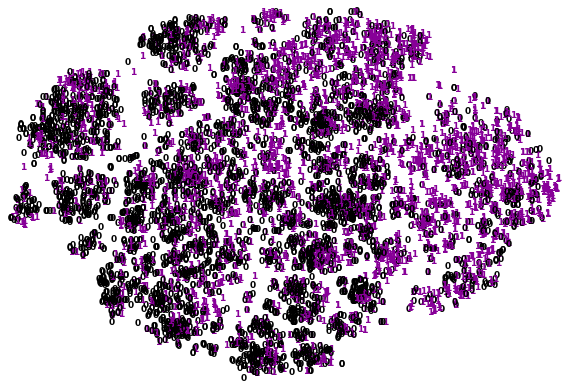

In [11]:
start_time = time()
X=data
y=y2
porcentaje=30 # porcentaje sobre 100 de datos del dataset que se utilizan para mostrar la proyección t-SNE
X_red = manifold.TSNE(n_components=2).fit_transform(X[:int(len(X)*porcentaje/100)][:-1])
plot_clustering(X_red,y)

elapsed_time = time() - start_time
print("Tiempo de ejecución: %.10f segundos." % elapsed_time) 